<h1>Module 16 Project Template</h1>

Use the code below to help you analyze the data returned by the MBTA API:

In [56]:
mbtaURL = "https://api-v3.mbta.com/vehicles?filter[route]=1&include=trip"

import urllib.request, json
with urllib.request.urlopen(mbtaURL) as url:
    data = json.loads(url.read().decode())
   
    with open('data.json', 'w') as outfile:
        json.dump(data, outfile)
   
    with open('data.txt', 'w') as outfile:
        json.dump(json.dumps(data, indent=4, sort_keys=True), outfile)
       
    print(json.dumps(data, indent=4, sort_keys=True))


{
    "data": [
        {
            "attributes": {
                "bearing": 138,
                "current_status": "IN_TRANSIT_TO",
                "current_stop_sequence": 17,
                "direction_id": 1,
                "label": "1924",
                "latitude": 42.33693402,
                "longitude": -71.077715679,
                "occupancy_status": "MANY_SEATS_AVAILABLE",
                "speed": null,
                "updated_at": "2022-08-30T10:15:37-04:00"
            },
            "id": "y1924",
            "links": {
                "self": "/vehicles/y1924"
            },
            "relationships": {
                "route": {
                    "data": {
                        "id": "1",
                        "type": "route"
                    }
                },
                "stop": {
                    "data": {
                        "id": "59",
                        "type": "stop"
                    }
                },
                "t

Use the code below to read the data from your MySQL database and store it in a pandas dataframe.  

You you need to install pymysql to run the code:

pip install pymysql

In [57]:
pip install pymysql

Note: you may need to restart the kernel to use updated packages.


In [58]:
import os
import pymysql
import pandas as pd
from datetime import datetime

host = '127.0.0.1'
port = '3306'
user = 'root'
password = 'MyNewPass'
database = 'MBTAdb'

conn = pymysql.connect(
    host=host,
    port=int(3306),
    user="root",
    passwd=password,
    db=database,
    charset='utf8mb4')

df = pd.read_sql_query("SELECT * FROM mbta_buses",
    conn)

df.tail(10)


The code below saves the data as a csv file to the local directory as a backup.

In [59]:
df.to_csv('mbta.csv')

In [60]:
df = pd.read_csv('mbta.csv')
df

,Unnamed: 0,record_num,id,latitude,longitude,bearing,current_stop_sequence,direction_id,speed,updated_at
0,0,1,y1898,42.329830,-71.083780,90,1.0,0,NaN,2022-08-22 01:50:07
1,1,2,y1884,42.331507,-71.077752,293,21.0,1,NaN,2022-08-22 01:50:48
2,2,3,y1873,42.329870,-71.083960,90,1.0,1,NaN,2022-08-22 01:49:55
3,3,4,y1833,42.360102,-71.094881,128,10.0,1,NaN,2022-08-22 01:50:47
4,4,5,y1814,42.358908,-71.093400,0,15.0,0,NaN,2022-08-22 01:50:48
...,...,...,...,...,...,...,...,...,...,...
85299,85299,85300,y1851,42.366713,-71.106059,0,6.0,1,NaN,2022-08-27 22:02:54
85300,85300,85301,y1800,42.373120,-71.117690,270,1.0,0,NaN,2022-08-27 22:02:47
85301,85301,85302,y1779,42.347219,-71.087567,0,12.0,1,NaN,2022-08-27 22:02:56
85302,85302,85303,y1775,42.332444,-71.081350,0,22.0,1,NaN,2022-08-27 22:03:07


In [61]:
df['id'].value_counts()

y1895    5848
y1903    5504
y1899    4180
y1737    4084
y1853    3804
         ... 
y1788      71
y1750      71
y1871      62
y1888      24
y1907      20
Name: id, Length: 73, dtype: int64

<h1>What is the average time it takes for a bus to complete the route</h1>

I used y1895 as the bus to conduct analysis on for this section. I wrote several methods that completed the key data processing so that I could extract the timnings and then complete an average calculation.

In [62]:
def timings(df, bus_id):
    stop_data = df[(df['id'] == bus_id)]
    return stop_data

In [63]:
def getUniqueVals(initial_list):
    ul = []
    for item in initial_list:
        if item not in ul:
            ul.append(item)
    del ul[0]
    return ul

In [64]:
def getIndices(df, num):
    indices = [0]
    max_indices = []
    for index, row in df.iterrows():
        if row['current_stop_sequence'] == num:
            indices.append(index)
        if row['current_stop_sequence'] != num:
            max_indices.append(max(indices))
    return getUniqueVals(max_indices)

In [65]:
def combinedIndexList(first_stop_list, last_stop_list):
    if first_stop_list[0] > last_stop_list[0]:
        del last_stop_list[0]
    combined_list = first_stop_list + last_stop_list
    combined_list.sort()
    return combined_list

In [66]:
def getMinStopNumber(df, bus_id):
    return df[df['id'] == bus_id]['current_stop_sequence'].min()

def getMaxStopNumber(df, bus_id):
    return df[df['id'] == bus_id]['current_stop_sequence'].max()

In [67]:
def avgTimeInMin(sample_list):
    time = (sum(sample_list)/len(sample_list))/60
    return round(time, 2)

In [68]:
def getTripTimes(df, bus_id):    
    test = timings(df, bus_id)

    first = getMinStopNumber(df, bus_id)
    last = getMaxStopNumber(df, bus_id)

    fsindexlist = getIndices(test, first)
    lsindexlist = getIndices(test, last)
    
    start_end_df = test.loc[combinedIndexList(fsindexlist,lsindexlist)]
    
    datetime_diff = datetime.strptime(start_end_df.iloc[1]['updated_at'], '%Y-%m-%d %H:%M:%S') - datetime.strptime(start_end_df.iloc[0]['updated_at'], '%Y-%m-%d %H:%M:%S')
    benchmark_time = datetime_diff.total_seconds()
    
    times = []
    last_time = None
    for index, row in start_end_df.iterrows():
        if row['current_stop_sequence'] == first:
            start_time = datetime.strptime(row['updated_at'], '%Y-%m-%d %H:%M:%S')
            last_time = start_time
            time_taken = last_time - start_time
        if row['current_stop_sequence'] == last:
            end_time = datetime.strptime(row['updated_at'], '%Y-%m-%d %H:%M:%S')
            time_taken = end_time - last_time
        if (time_taken.total_seconds() >= 0.5*benchmark_time) and (time_taken.total_seconds() <= 1.5*benchmark_time):
            times.append(time_taken.total_seconds())
    
    return times

In [69]:
getTripTimes(df, 'y1895')

[2334.0,
 2016.0,
 2645.0,
 2393.0,
 2174.0,
 2668.0,
 3034.0,
 2771.0,
 2113.0,
 2303.0,
 2520.0,
 2478.0,
 2855.0,
 2790.0,
 2847.0,
 2807.0]

In [70]:
print(f'The average time for Bus y1895 to complete Route 1 is {avgTimeInMin(getTripTimes(df, "y1895"))} minutes.')

The average time for Bus y1895 to complete Route 1 is 42.45 minutes.


The average time for Bus y1895 to complete Route 1 is approximately 42.45 minutes.

<h1>Provide a Visualization based on the data</h1>

I used the efforts of the first section to quickly calculate average times of other Buses. I then provided a sample visualization of the average times of those buses.

In [71]:
import matplotlib.pyplot as plt
import numpy as np

bus_list = ['y1895', 'y1899', 'y1737', 'y1853']
average_times = []
for bus_id in bus_list:
    average_times.append(avgTimeInMin(getTripTimes(df, bus_id)))
average_times = np.array(average_times)
average_times

array([42.45, 56.92, 38.04, 52.87])

Text(0, 0.5, 'Minutes')

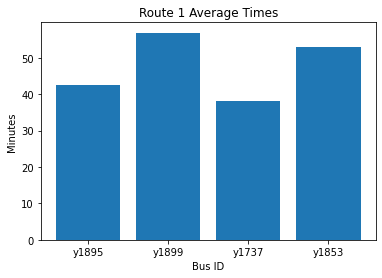

In [72]:
plt.bar(bus_list,average_times)
plt.title('Route 1 Average Times')
plt.xlabel('Bus ID')
plt.ylabel('Minutes')

In [73]:
list_of_buses = list(df['id'].value_counts().index)

<BarContainer object of 73 artists>

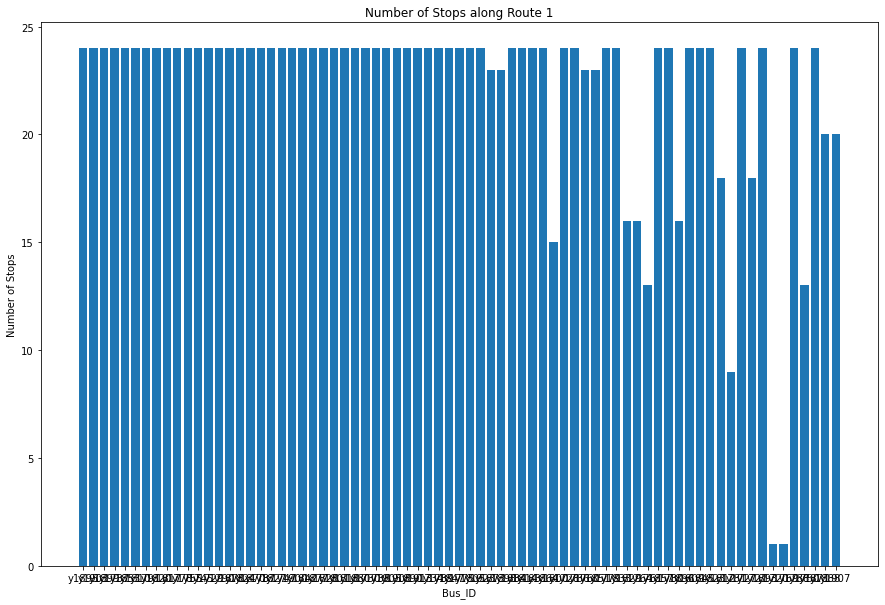

In [74]:
number_of_stops = []
for bus_id in list_of_buses:
    number_of_stops.append(getMaxStopNumber(df, bus_id))
number_of_stops = np.array(number_of_stops)
plt.figure(figsize=(15,10))
plt.title('Number of Stops along Route 1')
plt.xlabel('Bus_ID')
plt.ylabel('Number of Stops')
plt.bar(list_of_buses, number_of_stops)


<h1>Give an estimate of the speed of the bus from current_stop_sequence = 1 to the last  current_stop_sequence. </h1> 

Note: You can use the haversine Python library to calculate the distance between two points, given two longitude and latitude coordinates.

In [75]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.


In [76]:
from haversine import haversine, Unit

def getEstimatedSpeed(df, bus_id):    
    test = timings(df, bus_id)

    first = getMinStopNumber(df, bus_id)
    last = getMaxStopNumber(df, bus_id)

    fsindexlist = getIndices(test, first)
    lsindexlist = getIndices(test, last)
    
    start_end_df = test.loc[combinedIndexList(fsindexlist,lsindexlist)]
    
    first_stop_latlon = (start_end_df.iloc[0]['latitude'], start_end_df.iloc[0]['longitude'])
    last_stop_latlon = (start_end_df.iloc[1]['latitude'], start_end_df.iloc[0]['longitude'])
    
    distance = haversine(first_stop_latlon, last_stop_latlon, unit='mi')
    time = avgTimeInMin(getTripTimes(df, bus_id))
    return round(distance/(time/60),2)

In [77]:
print(f'The estimated speed for Bus y1895 to complete Route 1 is {getEstimatedSpeed(df, "y1895")} mph.')

The estimated speed for Bus y1895 to complete Route 1 is 4.15 mph.


The estimated speed for Bus y1895 to complete Route 1 is 4.15 mph. This number was attained using the Haversine library as well as the earlier code that calculated the average time for route completion. The speed is then returned by calculating distance/time, ensuring we are using miles and minutes for mph as the speed units. It is important to remember that this is not the true average speed of the bus because the distance calculated by Haversine is not necessarily the actual distance covered by the bus from the first to last stops.